In [1]:
import ForwardDiff
import PyPlot
using PyPlot
import Base.convert


convert(::Type{Float64}, x::ForwardDiff.GradientNumber) = Float64(x.value)
function convert(::Array{Float64}, x::Array{ForwardDiff.GradientNumber}) 
    y = zeros(size(x)); 
    for i in 1:prod(size(x)) 
        y[i] = convert(Float64, x[i]) 
    end
    return y
end

convert(::Type{Float64}, x::ForwardDiff.HessianNumber) = Float64(x.gradnum.value)
function convert(::Array{Float64}, x::Array{ForwardDiff.HessianNumber}) 
    y = zeros(size(x)); 
    for i in 1:prod(size(x)) 
        y[i] = convert(Float64, x[i]) 
    end
    return y
end

objc[20698]: Class TKApplication is implemented in both /System/Library/Frameworks/Tk.framework/Versions/8.5/Tk and /Users/msyoon/anaconda/lib/libtk8.5.dylib. One of the two will be used. Which one is undefined.
objc[20698]: Class TKMenu is implemented in both /System/Library/Frameworks/Tk.framework/Versions/8.5/Tk and /Users/msyoon/anaconda/lib/libtk8.5.dylib. One of the two will be used. Which one is undefined.
objc[20698]: Class TKContentView is implemented in both /System/Library/Frameworks/Tk.framework/Versions/8.5/Tk and /Users/msyoon/anaconda/lib/libtk8.5.dylib. One of the two will be used. Which one is undefined.
objc[20698]: Class TKWindow is implemented in both /System/Library/Frameworks/Tk.framework/Versions/8.5/Tk and /Users/msyoon/anaconda/lib/libtk8.5.dylib. One of the two will be used. Which one is undefined.


convert (generic function with 656 methods)

In [2]:
using MAT
ratdata = matread("testdata.mat")
#ratdata = matread("chrono_B069_rawdata.mat")

Dict{ByteString,Any} with 5 entries:
  "ratname"      => "B069"
  "daterange"    => 1x2 Array{Any,2}:…
  "avgdata"      => Dict{ASCIIString,Any}("is_probe"=>1x64537 Array{Bool,2}:…
  "rawdata"      => Dict{ASCIIString,Any}("is_probe"=>1x64537 Array{Any,2}:…
  "total_trials" => 64537.0

In [3]:
function trialdata(ratdata, trial)
    if ratdata["rawdata"]["pokedR"][trial] > 0
        rat_choice = 1;  # "R"
    else
        rat_choice = -1; # "L"
    end;
    
    return ratdata["rawdata"]["rightbups"][trial], ratdata["rawdata"]["leftbups"][trial], 
    ratdata["rawdata"]["T"][trial], rat_choice
end

RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, 1)

(
1x8 Array{Float64,2}:
 0.0  0.001135  0.011165  0.01892  0.10638  0.20342  0.329645  0.33776,

1x3 Array{Float64,2}:
 0.0  0.19235  0.34361,

0.35095899999999747,-1)

In [4]:
"""
function bin_centers = make_bins(B, dx, binN)

Makes a series of points that will indicate bin centers. The first and
last points will indicate sticky bins. No "bin edges" are made-- the edge
between two bins is always implicity at the halfway point between their
corresponding centers. The center bin is always at x=0; bin spacing
(except for last and first bins) is always dx; and the position
of the first and last bins is chosen so that |B| lies exactly at the
midpoint between 1st (sticky) and 2nd (first real) bins, as well as
exactly at the midpoint between last but one (last real) and last
(sticky) bins.

Playing nice with ForwardDiff means that the *number* of bins must be predetermined.
So this function will not actually set the number of bins; what it'll do is determine their
locations. To accomplish this separation, the function uses as a third parameter binN,
which should be equal to the number of bins with bin centers > 0, as follows: 
   binN = ceil(B/dx)
and then the total number of bins will be 2*binN+1, with the center one always corresponding
to position zero. Use non-differentiable types for B and dx for this to work.
"""
function make_bins(B, dx, binN)
    bins = collect(1.0:binN)*B
    bins = dx*bins/B

    if bins[end] == B
        bins[end] = B + dx
    else
        bins[end] = 2*B - bins[end-1]
    end

    bins = [-bins[end:-1:1]; 0; bins]
    return bins
end;

In [5]:
bins = make_bins(4.1,0.25,ceil(4.1/0.25))
bin_centers = bins
bins

35-element Array{Float64,1}:
 -4.2 
 -4.0 
 -3.75
 -3.5 
 -3.25
 -3.0 
 -2.75
 -2.5 
 -2.25
 -2.0 
 -1.75
 -1.5 
 -1.25
  ⋮   
  1.5 
  1.75
  2.0 
  2.25
  2.5 
  2.75
  3.0 
  3.25
  3.5 
  3.75
  4.0 
  4.2 

In [6]:
# Global variables 
epsilon = 10.0^(-10);
dx = 0.25;
dt = 0.02;

sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   


sigma = params[1];
lam   = params[2];
c     = params[3];

# sigma = sqrt(dt)*sigma;
sigma_sbin = convert(Float64, sigma)

F = collect(1.0:length(bins))*collect(1.0:length(bins))';
F = 0.0*sigma*F; # Multiplying by that sigma is needed, 
                 # for type casting reasons I do not understand...

mus      = (bins + c/lam)*exp(lam*dt) - c/lam

35-element Array{Float64,1}:
 -4.2044 
 -4.004  
 -3.7535 
 -3.503  
 -3.2525 
 -3.002  
 -2.7515 
 -2.501  
 -2.2505 
 -2.0    
 -1.7495 
 -1.499  
 -1.2485 
  ⋮      
  1.50701
  1.75751
  2.00801
  2.25851
  2.50901
  2.75951
  3.01001
  3.26051
  3.51101
  3.76151
  4.01201
  4.21241

In [7]:
sbinsize = 0.1*sigma_sbin
swidth   = 4*sigma_sbin
sbins    = collect(-swidth:sbinsize:swidth+epsilon)
ps       = exp(-sbins.^2/(2*sigma^2)) / sqrt(2*sigma^2)
ps       = ps/sum(ps);

base_sbins = sbins;

sbins = collect(0:(length(base_sbins)-1))*sbinsize
sbins = sbins + mus[2]-swidth

81-element Array{Float64,1}:
 -8.004   
 -7.904   
 -7.804   
 -7.704   
 -7.604   
 -7.504   
 -7.404   
 -7.304   
 -7.204   
 -7.104   
 -7.004   
 -6.904   
 -6.804   
  ⋮       
 -1.104   
 -1.004   
 -0.904004
 -0.804004
 -0.704004
 -0.604004
 -0.504004
 -0.404004
 -0.304004
 -0.204004
 -0.104004
 -0.004004

In [ ]:
sbins = collect(0:(length(base_sbins)-1))*sbinsize
sbins = sbins + mus[6]-swidth
bin_centers = bins
find(bin_centers .<= sbins[9])

In [8]:
"""
function F = Fmatrix([sigma, lambda, c], bin_centers)

Uses globals
    dt
    dx
    epsilon       (=10.0^-10)

Returns a square Markov matrix of transition probabilities. 
Plays nice with ForwardDiff-- that is why bin_centers is a global vector (so that the rem
operations that go into defining the bins, which ForwardDiff doesn't know how to deal with,
stay outside of this differentiable function)

sigma  should be in (accumulator units) per (second^(1/2))
lambda should be in s^-1
c      should be in accumulator units per second
bin_centers should be a vector of the centers of all the bins. Edges will be at midpoints
       between the centers, and the first and last bin will be sticky.

dx is not used inside Fmatrix, because bin_centers specifies all we need to know.
dt *is* used inside Fmatrix, to convert sigma, lambda, and c into timestep units
"""
function Fmatrix(params::Vector, bin_centers)
    sigma = params[1];
    lam   = params[2];
    c     = params[3];

#     sigma = sqrt(dt)*sigma;
    sigma_sbin = convert(Float64, sigma)

    F = collect(1.0:length(bin_centers))*collect(1.0:length(bin_centers))';
    F = 0.0*sigma*F; # Multiplying by that sigma is needed, 
                     # for type casting reasons I do not understand...

    # amyoon : added condition if lambda=0 
    if lam == 0
        mus = bin_centers*exp(lam*dt)
    else
        mus = (bin_centers + c/lam)*exp(lam*dt) - c/lam
    end
    
    sbinsize = 0.1*sigma_sbin
    swidth   = 5*sqrt(sigma_sbin)#4*sigma_sbin
    sbins    = collect(-swidth:sbinsize:swidth+epsilon)
    ps       = exp(-sbins.^2/(2*sigma^2))#exp(-sbins.^2/(2*sigma^2)) / sqrt(2*sigma^2)
    ps       = ps/sum(ps);

    base_sbins = sbins;

    println(sbinsize)
    
    for j in 1:length(bin_centers)
        # sbins = [mus[j] - swidth : sbinsize : mus[j] + swidth+epsilon]
        sbins = collect(0:(length(base_sbins)-1))*sbinsize
        sbins = sbins + mus[j]-swidth
        
        if j==1
            println(swidth)
            println(sbins)
        end
        
        for k in 1:length(sbins)
            if sbins[k] < (bin_centers[1] + bin_centers[2])/2
                F[1,j] = F[1,j] + ps[k]
            elseif (bin_centers[end]+bin_centers[end-1])/2 <= sbins[k]
                F[end,j] = F[end,j] + ps[k]
            else
                bot = find(bin_centers .<= sbins[k])[end]
                top = bot+1
                F[bot,j] = F[bot,j] + 
                    ps[k]*(bin_centers[top] - sbins[k])/(bin_centers[top] - bin_centers[bot])
                F[top,j] = F[top,j] + 
                    ps[k]*(sbins[k] - bin_centers[bot])/(bin_centers[top] - bin_centers[bot])
                
                if j == 1
                    @printf("%d %d\n",bot,top)
                end
            end
        end
    end
    F[:,1] = 0; F[:,end] = 0; F[1,1] = 1; F[end,end] = 1;
    return F
end

Fmatrix (generic function with 1 method)

In [ ]:
F = Fmatrix([0.2, 0, 0.0],bin_centers) # Fi
F

In [9]:
"""
function F = Fmatrix([sigma, lambda, c], bin_centers)

Uses globals
    dt
    dx
    epsilon       (=10.0^-10)

Returns a square Markov matrix of transition probabilities. 
Plays nice with ForwardDiff-- that is why bin_centers is a global vector (so that the rem
operations that go into defining the bins, which ForwardDiff doesn't know how to deal with,
stay outside of this differentiable function)

sigma  should be in (accumulator units) per (second^(1/2))
lambda should be in s^-1
c      should be in accumulator units per second
bin_centers should be a vector of the centers of all the bins. Edges will be at midpoints
       between the centers, and the first and last bin will be sticky.

dx is not used inside Fmatrix, because bin_centers specifies all we need to know.
dt *is* used inside Fmatrix, to convert sigma, lambda, and c into timestep units
"""
function Fmatrix(params::Vector, bin_centers)
    sigma2 = params[1];
    lam   = params[2];
    c     = params[3];

#     sigma = sqrt(dt)*sigma;
    sigma2_sbin = convert(Float64, sigma2)

    F = collect(1.0:length(bin_centers))*collect(1.0:length(bin_centers))';
    F = 0.0*sigma2*F; # Multiplying by that sigma is needed, 
                     # for type casting reasons I do not understand...

    # amyoon : added condition if lambda=0 
    if lam == 0
        mus = bin_centers*exp(lam*dt)
    else
        mus = (bin_centers + c/lam)*exp(lam*dt) - c/lam
    end

#     sbinsize = 0.1*sigma_sbin
#     swidth   = 4*sigma_sbin
#     sbins    = collect(-swidth:sbinsize:swidth+epsilon)

    n_sbins = max(70, ceil(10*sqrt(sigma2_sbin)/dx))
    
    swidth = 5*sqrt(sigma2_sbin)
    sbinsize = swidth/n_sbins;#sbins[2] - sbins[1]
    sbins    = collect(-swidth:sbinsize:swidth)

    ps       = exp(-sbins.^2/(2*sigma2))#exp(-sbins.^2/(2*sigma^2)) / sqrt(2*sigma^2)
    ps       = ps/sum(ps);

    base_sbins = sbins;
        
    for j in 2:length(bin_centers)
        sbins = collect(0:(length(base_sbins)-1))*sbinsize
        sbins = sbins + mus[j]-swidth

        for k in 1:length(sbins)
            if sbins[k] < bin_centers[1] #(bin_centers[1] + bin_centers[2])/2
                F[1,j] = F[1,j] + ps[k]
            elseif bin_centers[end] <= sbins[k]#(bin_centers[end]+bin_centers[end-1])/2 <= sbins[k]
                F[end,j] = F[end,j] + ps[k]
            else # more condition
                if (sbins[k] > bin_centers[1] && sbins[k] < bin_centers[2])
                    lp = 1; hp = 2;
                elseif (sbins[k] > bin_centers[end-1] && sbins[k] < bin_centers[end])
                    lp = length(bin_centers)-1; hp = length(bin_centers);
                else 
                    lp = find(bin_centers .<= sbins[k])[end]#Int(floor((sbins[k]-bin_centers[2])/dx) + 1);
                    hp = lp+1#Int(ceil((sbins[k]-bin_centers[2])/dx) + 1);
                end

                if lp < 1 
                    lp = 1; 
                end
                if hp < 1 
                    hp = 1;
                end

                if lp == hp
                    F[lp,j] = F[lp,j] + ps[k]
                else
                    F[hp,j] = F[hp,j] + ps[k]*(sbins[k] - bin_centers[lp])/(bin_centers[hp] - bin_centers[lp])
                    F[lp,j] = F[lp,j] + ps[k]*(bin_centers[hp] - sbins[k])/(bin_centers[hp] - bin_centers[lp])
                end                   
            end
        end
    end
    F[:,1] = 0; F[:,end] = 0; F[1,1] = 1; F[end,end] = 1;
    return F
end

Fmatrix (generic function with 1 method)

In [10]:
F = Fmatrix([0.2, 0, 0.0],bin_centers) # Fi
F

35x35 Array{Float64,2}:
 1.0  0.41182      0.218907     0.0917964    …  0.0          0.0          0.0
 0.0  0.197142     0.172131     0.112014        0.0          0.0          0.0
 0.0  0.187228     0.217923     0.187228        0.0          0.0          0.0
 0.0  0.119939     0.187228     0.217923        0.0          0.0          0.0
 0.0  0.0571377    0.119939     0.187228        0.0          0.0          0.0
 0.0  0.0202246    0.0571377    0.119939     …  0.0          0.0          0.0
 0.0  0.00531176   0.0202246    0.0571377       0.0          0.0          0.0
 0.0  0.00103206   0.00531176   0.0202246       0.0          0.0          0.0
 0.0  0.000148294  0.00103206   0.00531176      0.0          0.0          0.0
 0.0  1.59548e-5   0.000148294  0.00103206      0.0          0.0          0.0
 0.0  1.11105e-6   1.59548e-5   0.000148294  …  0.0          0.0          0.0
 0.0  0.0          1.11105e-6   1.59548e-5      0.0          0.0          0.0
 0.0  0.0          0.0          1.11105e

In [ ]:
F = Fmatrix(params,bin_centers)
F

In [11]:
"""
function logProbRight(params::Vector)

Needs to read globals 
    Nsteps number of timesteps to simulate
    RightClickTimes   vector with elements indicating times of right clicks
    LeftClickTimes    vector with elements indicating times of left clicks

Mutates globals
    a      (column vector representing distribution of values of accumulator a)

    a_trace (length(bin_centers)-by-Nsteps+1), a trace of the distribution of a as 
            a function of time
    c_trace (row vector Nsteps+1 long, effective value of c as 
            a function of time after adaptation)

Takes params
    sigma_a = params[1]; sigma_s = params[2]; sigma_i = params[3]; 
    lambda = params[4]; B = params[5]; bias = params[6]; 
    phi = params[7]; tau_phi = params[8]; lapse = params[9]

Returns the log of the probability that the agent chose Right. 
"""

function logProbRight(params::Vector)
    sigma_a = params[1]; sigma_s = params[2]; sigma_i = params[3]; 
    lambda = params[4]; B = params[5]; bias = params[6]; 
    phi = params[7]; tau_phi = params[8]; lapse = params[9]
    
    global a, dx, dt, Nsteps, LeftClickTimes, RightClickTimes, a_trace, c_trace
    
    LeftClicks  = zeros(1, Nsteps); if isempty(RightClickTimes) RightClickTimes = zeros(0) end;
    RightClicks = zeros(1, Nsteps); if isempty(LeftClickTimes ) LeftClickTimes  = zeros(0) end;
    for i in ceil((LeftClickTimes+epsilon)/dt)  LeftClicks[Int(i)]  = 1 end
    for i in ceil((RightClickTimes+epsilon)/dt) RightClicks[Int(i)] = 1 end
    
    my_B = convert(Float64, B) # my_B won't be differentiated; ForwardDiff can't do ceil()
    my_bias = convert(Float64, bias)  # my_bias won't be differentiated' FD can't do floor()
    binN = Int(ceil(my_B/dx))  
    binBias = Int(floor(my_bias/dx)) + binN+1  
    bin_centers = make_bins(B, dx, binN) 

    a_trace = zeros(length(bin_centers), Nsteps+1); c_trace = zeros(1, Nsteps+1)
    a = zeros(length(bin_centers),1)*sigma_a*0.0; # That weirdo inexact error thing
    a[binN+1] = 1-2*lapse; a[1] = lapse; a[end] = lapse;
    c_eff   = 1;
    
    Fi = Fmatrix(collect([sigma_i/sqrt(dt); lambda; 0.0]), bin_centers); a = Fi*a;
    a_trace[:,1] = a;

    F0 = Fmatrix(collect([sigma_a; lambda; 0.0]), bin_centers)
    for i in 1:Nsteps 
        c_eff = 1 + (c_eff - 1)*exp(-dt/tau_phi)
        if (RightClicks[i]==0) & (LeftClicks[i]==0)
            a = F0*a
        elseif (RightClicks[i]==1) & (LeftClicks[i]==1)
            c_eff = 0
            a = F0*a
        else
            net_sigma = sqrt(sigma_a^2 + (sigma_s*c_eff)^2/dt)
            F = Fmatrix(collect([net_sigma; lambda; (RightClicks[i] - LeftClicks[i])*c_eff/dt]), bin_centers)
            a = F*a
            c_eff = c_eff*phi
        end
        c_trace[i+1]   = convert(Float64, c_eff)
        a_trace[:,i+1] = convert(Array{Float64}, a)
    end;

    pright = sum(a[binBias+1:end]) + 
        a[binBias]*0.5*(dx/2 - (bias - bin_centers[binBias]))/(dx/2)
    return log(pright)
end



function logLike(params::Vector)
    global rat_choice
    if rat_choice > 0
        return logProbRight(params)
    elseif rat_choice < 0
        return log(1 - exp(logProbRight(params)))
    else
        error("Rat did what?? It was neither R nor L")
    end
end

logLike (generic function with 1 method)

In [60]:
"""
version with net_input / total_input

function logProbRight(params::Vector)

Needs to read globals 
    Nsteps number of timesteps to simulate
    RightClickTimes   vector with elements indicating times of right clicks
    LeftClickTimes    vector with elements indicating times of left clicks

Mutates globals
    a      (column vector representing distribution of values of accumulator a)

    a_trace (length(bin_centers)-by-Nsteps+1), a trace of the distribution of a as 
            a function of time
    c_trace (row vector Nsteps+1 long, effective value of c as 
            a function of time after adaptation)

Takes params
    sigma_a = params[1]; sigma_s = params[2]; sigma_i = params[3]; 
    lambda = params[4]; B = params[5]; bias = params[6]; 
    phi = params[7]; tau_phi = params[8]; lapse = params[9]

Returns the log of the probability that the agent chose Right. 
"""

function logProbRight(params::Vector)
    sigma_a = params[1]; sigma_s = params[2]; sigma_i = params[3]; 
    lambda = params[4]; B = params[5]; bias = params[6]; 
    phi = params[7]; tau_phi = params[8]; lapse = params[9]
    
    global a, dx, dt, Nsteps, LeftClickTimes, RightClickTimes, a_trace, c_trace
    
    LeftClicks  = zeros(1, Nsteps); if isempty(RightClickTimes) RightClickTimes = zeros(0) end;
    RightClicks = zeros(1, Nsteps); if isempty(LeftClickTimes ) LeftClickTimes  = zeros(0) end;
    for i in ceil((LeftClickTimes+epsilon)/dt)  LeftClicks[Int(i)]  = LeftClicks[Int(i)] + 1 end
    for i in ceil((RightClickTimes+epsilon)/dt) RightClicks[Int(i)] = RightClicks[Int(i)] + 1 end
    
    my_B = convert(Float64, B) # my_B won't be differentiated; ForwardDiff can't do ceil()
    my_bias = convert(Float64, bias)  # my_bias won't be differentiated' FD can't do floor()
    binN = Int(ceil(my_B/dx))  
    binBias = Int(floor(my_bias/dx)) + binN+1  
    bin_centers = make_bins(B, dx, binN) 

    a_trace = zeros(length(bin_centers), Nsteps+1); 
    c_trace = zeros(1, Nsteps+1)
    
    a0 = zeros(length(bin_centers),1)*sigma_a*0.0; # That weirdo inexact error thing
    a0[binN+1] = 1-2*lapse; a0[1] = lapse; a0[end] = lapse;
    
    c_eff_r = 0
    c_eff_l = 0
    cnt_r = 0
    cnt_l = 0
    
    Fi = Fmatrix(collect([sigma_i; 0; 0.0]), bin_centers); 
    a = Fi*a0;
    a_trace[:,1] = a;

    F0 = Fmatrix(collect([sigma_a*dt; lambda; 0.0]), bin_centers)
    for i in 2:Nsteps 
        c_eff_tot = 0
        c_eff_net = 0
        if (RightClicks[i-1]==0) & (LeftClicks[i-1]==0)
            c_eff_tot = 0
            c_eff_net = 0

            a = F0*a
        else
            for j in 1:RightClicks[i-1]
                if cnt_r != 0 || j != 1
                    ici = RightClickTimes[cnt_r+j]-RightClickTimes[cnt_r+j-1]
                    c_eff_r = 1 + (c_eff_r*phi - 1)*exp(-ici/tau_phi)
                    c_eff_tot = c_eff_tot + c_eff_r
                    c_eff_net = c_eff_net + c_eff_r
                end
                if j == RightClicks[i-1]
                    cnt_r = cnt_r+j
                end
            end
            for j in 1:LeftClicks[i-1]
                if cnt_l != 0 || j != 1
                    ici = LeftClickTimes[cnt_l+j]-LeftClickTimes[cnt_l+j-1]
                    c_eff_l = 1 + (c_eff_l*phi - 1)*exp(-ici/tau_phi)
                    c_eff_tot = c_eff_tot + c_eff_l
                    c_eff_net = c_eff_net - c_eff_l
                end
                if j == LeftClicks[i-1]
                    cnt_l = cnt_l+j
                end
            end
            net_sigma = sigma_a*dt + (sigma_s*c_eff_tot)/40
            F = Fmatrix(collect([net_sigma; lambda; c_eff_net/dt]), bin_centers)
            a = F*a
        end
        
        c_trace[i]   = convert(Float64, c_eff_tot)
        a_trace[:,i] = convert(Array{Float64}, a)
    end;
#     plot(1:Nsteps+1,c_trace[:])    
#     imshow(a_trace, interpolation="none")
    pright = sum(a[binBias+2:end]) + 
    a[binBias]*((bin_centers[binBias+1] - bias)/dx/2) +
    a[binBias+1]*(0.5 + (bin_centers[binBias+1] - bias)/dx/2)
    
    return log(pright)
end



function logLike(params::Vector)
    global rat_choice
    if rat_choice > 0
#         println("Right")
        return logProbRight(params)
    elseif rat_choice < 0
#         println("Left")
        return log(1 - exp(logProbRight(params)))
    else
        error("Rat did what?? It was neither R nor L")
    end
end

logLike (generic function with 1 method)

In [61]:
""" 
function (LL, LLgrad, LLhessian, bin_centers, bin_times, a_trace) = 
    llikey(params, rat_choice, maxT=1, RightPulseTimes=[], LeftPulseTimes=[], dx=0.25, dt=0.02)

Computes the log likelihood according to Bing's model, and returns log likelihood, gradient, and hessian

params is a vector whose elements, in order, are
    sigma_a    square root of accumulator variance per unit time sqrt(click units^2 per second)
    sigma_s    standard deviation introduced with each click (will get scaled by click adaptation)
    sigma_i    square root of initial accumulator variance sqrt(click units^2)
    lambda     1/accumulator time constant (sec^-1). Positive means unstable, neg means stable
    B          sticky bound height (click units)
    bias       where the decision boundary lies (click units)
    phi        click adaptation/facilitation multiplication parameter
    tau_phi    time constant for recovery from click adaptation (sec)
    lapse      2*lapse fraction of trials are decided randomly

rat_choice     should be either "R" or "L"


RETURNS:


"""
function llikey(params::Vector; maxT=1, RightPulseTimes=[], LeftPulseTimes=[], dx=0.25, dt=0.02)

    global RightClickTimes, LeftClickTimes, Nsteps

#     RightClickTimes = filter(x -> x<=maxT, collect(RightPulseTimes))
#     LeftClickTimes  = filter(x -> x<=maxT, collect(LeftPulseTimes))    
#     Nsteps = Int(ceil(maxT/dt))
#     binN = Int(ceil(params[5]/dx)); 
#     bin_centers = make_bins(params[5], dx, binN); 
#     bin_times = dt*collect([0:Nsteps]);
    
    LLhessian, allresults = ForwardDiff.hessian(logLike, params, ForwardDiff.AllResults)

    LL     = ForwardDiff.value(allresults)
    LLgrad = ForwardDiff.gradient(allresults)

    LL = logLike(params)
    
#     return LL, zeros(size(params)), zeros(length(params), length(params)) # LLgrad, LLhessian
    return LL,LLgrad, LLhessian, length(params) # 
end

llikey (generic function with 1 method)

In [62]:
### =============== testing 1 ================= ####

epsilon = 10.0^(-10); 
dx = 0.25; 
dt = 0.02; 

# Parameters
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, 1)

Nsteps = Int(ceil(maxT/dt))

logLike(params)

### =========================================== ####

-2.5352539404380363

In [63]:
### =============== testing 2 ================= ####

# Parameters
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

LL, LLgrad, LLhess = llikey(params)
println(LL)
LLgrad
### =========================================== ####

-2.5352539404380363


9-element Array{Float64,1}:
  0.340888   
  0.0854286  
  1.00037    
  0.1405     
 -2.65784e-13
  0.982227   
 -1.29678    
 10.1754     
 11.7996     

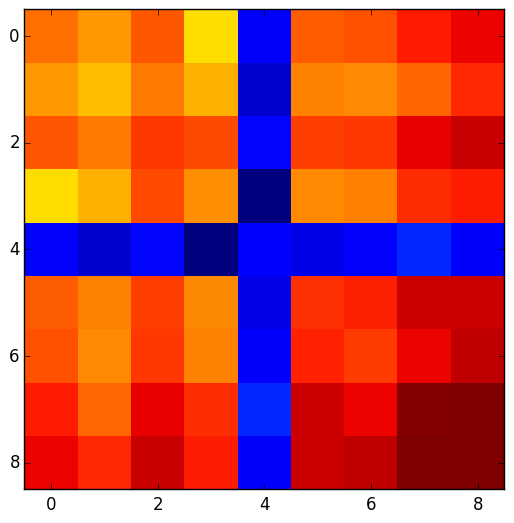

PyObject <matplotlib.image.AxesImage object at 0x31bef7750>

In [64]:
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

LL, LLgrad, LLhess = llikey(params, RightPulseTimes=[0.2 0.4])
imshow(log(abs(LLhess)), interpolation="none")

In [24]:
LL

-2.561430530032297

In [25]:
LLgrad

9-element Array{Float64,1}:
  0.347533   
  0.0871014  
  1.01995    
  0.149199   
 -1.26215e-13
  0.743056   
 -1.27612    
 10.0123     
 12.1715     

In [68]:
function multiLikey(ratdata, params, ntrials)
    LL        = 0
    LLgrad    = zeros(size(params))
    LLhessian = zeros(length(params), length(params))
    global rat_choice
    
    for i in 1:ntrials
        RClickTimes, LClickTimes, maxT, rat_choice = trialdata(ratdata, i)
        LLi, LLgradi, LLhessiani = llikey(params)

#         LL        = LL + LLi;
#         LLgrad    = LLgrad + LLgradi;
#         LLhessian = LLhessian + LLhessiani;

        println(i, " - LL : " , LLi)
        println(LLgradi)
        
    end

#     return LL, LLgrad, LLhessian
end

multiLikey (generic function with 1 method)

In [69]:
epsilon = 10.0^(-10); 
dx = 0.25; 
dt = 0.02; 

# Parameters
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]

# epsilon = 10.0^(-10); dx = 0.125; dt = 0.02; Nsteps = Int(ceil(1.0/dt))

# sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
# sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
# lam = -0.0005; B = 4.1; bias = 0.1; 
# phi = 0.3; tau_phi = 0.1; lapse = 0.05;
# params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

@time multiLikey(ratdata, params, 10)

1 - LL : -2.5352539404380363
[0.3408884804283798,0.08542855014353413,1.0003691248769657,0.1404998912583648,-2.6578437782586314e-13,0.9822273525908068,-1.2967840231752528,10.175394512958237,11.799594529818792]
2 - LL : -0.0825575942546292
[-0.029337279370151806,-0.007352085463839664,-0.0860929898625771,-0.012091592406240314,2.2873728483581153e-14,-0.08453168676087097,0.11160281838457377,-0.8757068914532705,-1.0154875305284432]
3 - LL : -0.0825575942546292
[-0.029337279370151806,-0.007352085463839664,-0.0860929898625771,-0.012091592406240314,2.2873728483581153e-14,-0.08453168676087097,0.11160281838457377,-0.8757068914532705,-1.0154875305284432]
4 - LL : -0.0825575942546292
[-0.029337279370151806,-0.007352085463839664,-0.0860929898625771,-0.012091592406240314,2.2873728483581153e-14,-0.08453168676087097,0.11160281838457377,-0.8757068914532705,-1.0154875305284432]
5 - LL : -2.5352539404380363
[0.3408884804283798,0.08542855014353413,1.0003691248769657,0.1404998912583648,-2.6578437782586314e-

In [ ]:
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

@profile multiLikey(ratdata, params, 10)

In [ ]:
a = 1
b = 2
@printf("%d %d",a,b)

In [ ]:
a = [0 2]
for i=1:a[1]
    println('a')
end

In [ ]:
1==1 || 0